## Boston Survival Guide
##### *Team members: Alvaro Chinchayan, Leighton Li, Andrey Lifar, Yoki Liu, Sherry Zuo

#### Our team is interested in crimes that were reported in the Boston area (including 11 districts) from June 2015 to October 2018. 
#### The main purpose of our project is to analyze patterns of crimes, the potential incentives for crimes, as well as how other factors such as housing prices, income correlate with crimes.
#### Crime Data Source: https://www.kaggle.com/ankkur13/boston-crime-data 
#### Housing Data Source: https://www.zillow.com/boston-ma/home-values/
#### Income Data Source: https://statisticalatlas.com/county-subdivision/Massachusetts/Suffolk-County/Boston/Household-Income

### Table of Content
-1 Preview of data & Data Cleaning

-2 Data Analysis

- 2.1 Time Analysis

-- 2.1.1 Time series

-- 2.1.2 Year/month/week/day/hour with the most crimes

-- 2.1.3 Regression for time & time_Crime

- 2.2 Location Analysis

-- 2.2.1 Region/district/Street with the most crimes

-- 2.2.2 Distribution of crimes by Districts -- Bubble chart

-- 2.2.3 Location,Housing Prices and Crimes -- Distribution & Regression

-- 2.2.4 Location_Income & Location_Crime -- Distribution & Regression

- 2.3 Crime Attribute Analysis

-- 2.3.1 Crime Types 

-- 2.3.2 Example.shooting

- 2.4 Multivariate Analysis

-- 2.4.1 Location & Crime Type

-- 2.4.2 Crime Type & Time

-- 2.4.3 Time & Location

-3 Summary



### 1.Preview of data & Data Cleaning

First, let's indentify all the variables in our datasets.

- Crime dataset

In [1]:
%%bq query
SELECT *
FROM `team-6-is-perfect.Boston_Crime.boston_crime` 
LIMIT 3

QueryResultsTable job_sgJ4NTRfNWLWnw23LN0ATj5YWFVD

- Housing dataset

In [2]:
%%bq query
SELECT *
FROM `team-6-is-perfect.Boston_Crime.boston_housing`
LIMIT 3

QueryResultsTable job_HwwjAjP34DjG6Wq0csPPnvnW2LwQ

- Income dataset

In [3]:
%%bq query
SELECT *
FROM `team-6-is-perfect.Boston_Crime.boston_income_populationGrowth`
LIMIT 3

QueryResultsTable job_hlVxg9-yHGKXvih2zaB9gCStife6

In order to match all three datasets by district, we refer to the following website: https://bpdnews.com/districts

Since car accidents and aircrafts are not really under the crime category, so we want to create a new table without those two types of crimes. 
Also, we removed those missing values when we create the new table

In [4]:
%%bq query
create or replace table Boston_Crime.boston 
as (

WITH crime AS(
SELECT * EXCEPT ( OFFENSE_CODE, REPORTING_AREA, OFFENSE_DESCRIPTION,UCR_PART)
FROM `team-6-is-perfect.Boston_Crime.boston_crime`
),
housing AS (
SELECT Region_Name, District, `team-6-is-perfect.Boston_Crime.boston_housing`.current AS Housing_Price
FROM `team-6-is-perfect.Boston_Crime.boston_housing`
),
income AS (
SELECT District, Income 
FROM `team-6-is-perfect.Boston_Crime.boston_income_populationGrowth`
)



SELECT INCIDENT_NUMBER, OFFENSE_Code_GROUP as Crime_Type, crime.DISTRICT , IF(SHOOTING='Y',1,0) as SHOOTING, OCCURRED_ON_DATE, YEAR, MONTH, DAY_OF_WEEK, HOUR, STREET, Lat, Long, Region_Name, housing.Housing_Price, income.Income
FROM crime
INNER JOIN housing
ON crime.DISTRICT = housing.District
INNER JOIN income
ON crime.DISTRICT = income.District
WHERE Lat != -1 AND LONG != -1 AND Lat IS NOT NULL AND Lat IS NOT NULL AND OFFENSE_Code_GROUP != 'Motor Vehicle Accident Response' AND OFFENSE_Code_GROUP!= 'Aircraft' AND crime.DISTRICT IS NOT NULL
 )

QueryResultsTable job_Kgkmgd_5Lnt_7_XtfDvxsVlA7msJ

### 2.Data Analysis

### 2.1 Time Analysis

#### 2.1.1 Time series

Below is an overview of the number of crimes in time order

In [5]:
%%bq query -n crimes_year_month
SELECT TIMESTAMP(CONCAT(CAST(EXTRACT(year from OCCURRED_ON_DATE) AS STRING), "-", CAST(EXTRACT(month from OCCURRED_ON_DATE) AS STRING), "-01")) year_month, count(incident_number) as num_incident 
FROM Boston_Crime.boston
GROUP BY year_month;

In [6]:
%%chart annotation --d crimes_year_month

#### 2.1.2 Year/month/week/day/hour with the most crimes

#### Question: Which year has the highest amount of crimes?

In [7]:
%%bq query
SELECT year, count(year) as numcrime_year
FROM Boston_Crime.boston
Group by year
Order by numcrime_year DESC;

QueryResultsTable job_1IyhUAObJoJEWRGBSLwSG-t7QBCt

#### Answer: 2017 has the highest amount of crime

#### Question: Which month has the highest amount of crimes?

In [8]:
%%bq query
SELECT month, count(month) as numcrime_month
FROM Boston_Crime.boston
Group by month
Order by numcrime_month DESC
LIMIT 4;

QueryResultsTable job_L7Fxag56_qkjhi54rUKTpX0H8o6Q

#### Answer: On average, August has the highest amount of crimes.

#### Question: Which day of the week is the most dangerous?

In [9]:
%%bq query
SELECT day_of_week, count(day_of_week) as numcrime_weekday
FROM Boston_Crime.boston
Group by day_of_week
Order by numcrime_weekday DESC;

QueryResultsTable job_roVFqhthFT4yxJ-iQzn7ByK2OFUV

#### Answer: On average, Friday has the highest amount of crimes.

In [10]:
%%bq query -n crime_of_week
SELECT day_of_week, count (day_of_week) as day_of_week_crime_amount,Case when day_of_week = 'Monday' then 1
  when day_of_week = 'Tuesday' then 2
  when day_of_week = 'Wednesday' then 3
  when day_of_week = 'Thursday' then 4
  when day_of_week = 'Friday' then 5
  when day_of_week = 'Saturday' then 6
  when day_of_week = 'Sunday' then 7 end as weekday
FROM Boston_Crime.boston
Group by day_of_week
Order by weekday;

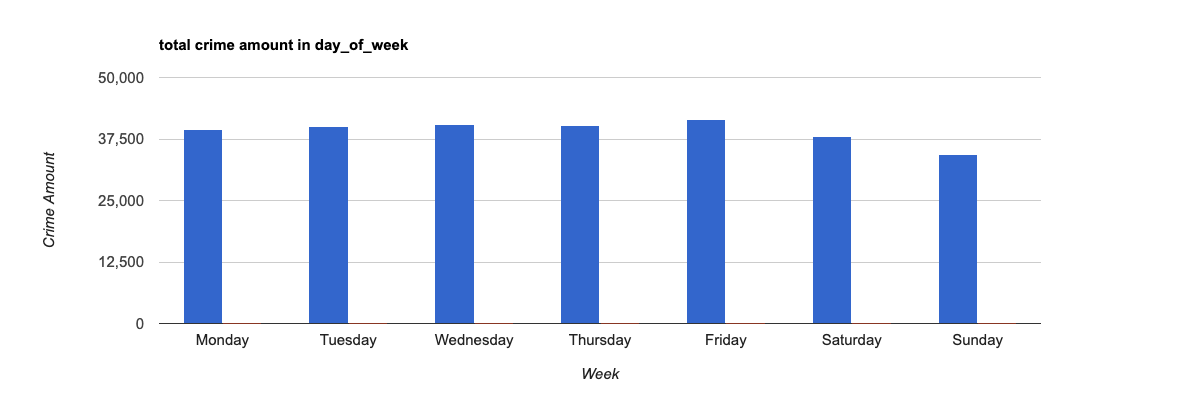

In [11]:
%%chart columns -d crime_of_week
title: total crime amount in day_of_week
height: 400
width: 1200
hAxis:
  title: Week
vAxis:
  title: Crime Amount
legend: none

#### Question: What time is the most dangerous of a day?

In [12]:
%%bq query
SELECT hour, count(hour) as numcrime_hour
FROM Boston_Crime.boston
Group by hour
Order by numcrime_hour DESC
LIMIT 5;

QueryResultsTable job_kqi1M7RXsZ5aEAPpsP0Ch8IOiItK

#### Answer: On average, crimes mostly occur at 5pm

In [13]:
%%bq query -n crime_of_hour
SELECT hour, count(hour) as numcrime_hour
FROM Boston_Crime.boston
Group by hour
Order by numcrime_hour DESC

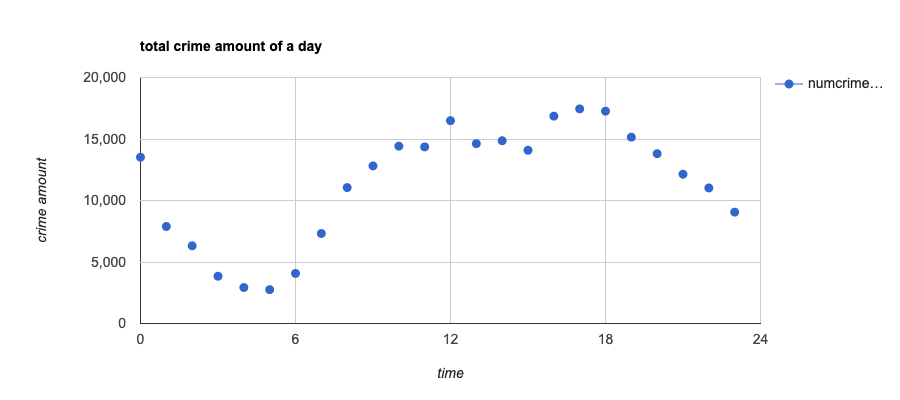

In [14]:
%%chart scatter -d crime_of_hour
title: total crime amount of a day
height: 400
width: 900
hAxis:
  title: time
vAxis:
  title: crime amount

#### Question: Do crimes usually happen during the day or the night?

In [15]:
%%bq query
SELECT Case when (hour >= 6 and hour <= 18) then 'daytime' else 'night' end as crime_happen_time, count(hour) as crime_hours
FROM Boston_Crime.boston
Group by crime_happen_time
Order by crime_happen_time

QueryResultsTable job_Izh6ClD5EioFX_M1A8LsjYbL-xXd

#### Answer: It's more likely for crimes to happen in the daytime

In [16]:
%%bq query -n crime_time 
SELECT Case when (hour >= 6 and hour <= 18) then 'daytime' else 'night' end as crime_happen_time, count(hour) as crime_hours
FROM Boston_Crime.boston
Group by crime_happen_time

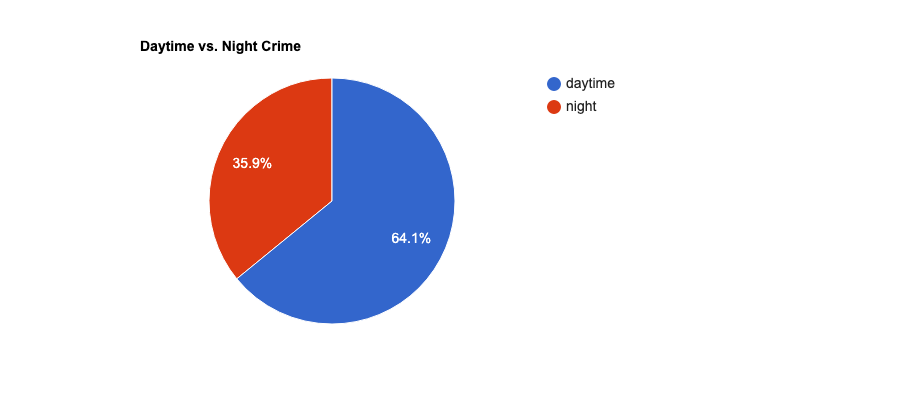

In [17]:
%%chart pie --d crime_time
title: Daytime vs. Night Crime
height: 400
width: 900

#### 2.1.3 Regression for time & time_Crime

#### For the regression, we create three dummy variables and assign values (0 or 1) by categorizing each of them. 

-	Month_type:

-- “colder” as 1: from November to April 

-- “warmer” as 0: from May to October 

-	Week_type:

-- Weekends as 1

-- Weekdays as 0

-	Hour_type:

-- Daytime as 1: from 6am to 6pm

-- Nighttime as 0: from 7pm to 5am

In [18]:
%%bq query
select
count (incident_number) as numcrime_in_time,
case when month in (11,12,1,2,3,4) then 1
else 0 end as month_type,
case when DAY_OF_WEEK in ('Saturday','Sunday') then 1
else 0 end as week_type,
case when HOUR >=6 and hour <=18 then 1
else 0 end as hour_type
FROM Boston_Crime.boston
group by month_type,week_type,hour_type

QueryResultsTable job_98dDTdQ1Dmd99KKAzDRujcBRHtGk

In [19]:
%%bq query
create or replace model`team-6-is-perfect.Boston_Crime.regression`
options(
model_type='linear_reg',
input_label_cols=['numcrime_in_time'])
as (select
count (incident_number) as numcrime_in_time,
case when month in (11,12,1,2,3,4) then 1
else 0 end as month_type,
case when DAY_OF_WEEK in ('Saturday','Sunday') then 1
else 0 end as week_type,
case when HOUR >=6 and hour <=18 then 1
else 0 end as hour_type
FROM Boston_Crime.boston
group by month_type,week_type,hour_type)

QueryResultsTable job_wmrCwLROXn7U3-q2MrZwhKkGC-_9

In [20]:
%%bq query
with regression_table as
(select
count (incident_number) as numcrime_in_time,
case when month in (11,12,1,2,3,4) then 1
else 0 end as month_type,
case when DAY_OF_WEEK in ('Saturday','Sunday') then 1
else 0 end as week_type,
case when HOUR >=6 and hour <=18 then 1
else 0 end as hour_type
FROM Boston_Crime.boston
group by month_type,week_type,hour_type)

select *
from
ML.evaluate( model`team-6-is-perfect.Boston_Crime.regression`, table regression_table)

QueryResultsTable job_hu9jF0kBDXu8n5HtrEuDA6af9e6C

In [21]:
%%bq query
with eval_table as
(select
count (incident_number) as numcrime_in_time,
case when month in (11,12,1,2,3,4) then 1
else 0 end as month_type,
case when DAY_OF_WEEK in ('Saturday','Sunday') then 1
else 0 end as week_type,
case when HOUR >=6 and hour <=18 then 1
else 0 end as hour_type
FROM Boston_Crime.boston
group by month_type,week_type,hour_type)

select *
from
ML.WEIGHTS( model`team-6-is-perfect.Boston_Crime.regression`, STRUCT(true AS standardize))

QueryResultsTable job_nZJtsmT1dl6g0yXMN6K5nPj9zgYe

#### Regression Function: predicted number of crime = 34126.823 - 5166.37 * month_type(dummy) - 17169.359 * week_type(dummy)+10282.926*hour_type(dummy)
#### R-square: 0.869 which is a reliable regression

### 2.2 Location Analysis

 #### 2.2.1 Region/District/Street with the most crimes

#### Question: Which neighboorhood is the most dangerous?

In [22]:
%%bq query
SELECT district, count(district) as numcrime_in_district
FROM Boston_Crime.boston
Group by district
Order by numcrime_in_district DESC
LIMIT 5;

QueryResultsTable job_02-iQ3XCPvllFikcb9gNGh4sGr21

#### Answer: The most dangerous district is B2 which is Roxbury.

#### Question: What are the most dangerous streets?

In [23]:
%%bq query
SELECT street, count(street) as numcrime_street
FROM Boston_Crime.boston
Group by street
Order by numcrime_street DESC
LIMIT 5;

QueryResultsTable job_WHS8l7jOxZZa9d6J5RLwglTRtCX9

#### Answer: The most dangerous street in Boston is Washington St.

#### 2.2.2 Distribution of crimes by Districts--bubble chart

#### We use a bubble chart to represent the distribution of crimes in different districts in Boston

In [24]:
%%bq query
SELECT distinct(district), count(district) as numcrime
FROM Boston_Crime.boston
GROUP BY district

QueryResultsTable job_tCP8DiR18dtYMprPQ1fVqDOeDBsM

In [25]:
%%bq query
SELECT distinct district, AVG(lat) AS lat, AVG(long) AS lon
FROM Boston_Crime.boston
GROUP BY district

QueryResultsTable job__65LbPFiCcUtNrfj0XOytMWvD47g

In [26]:
%%bq query
WITH temp1 AS(
SELECT distinct(district), count(district) as numcrime
FROM Boston_Crime.boston
GROUP BY district),
temp2 AS(
SELECT distinct district, AVG(lat) AS lat, AVG(long) AS lon
FROM Boston_Crime.boston
GROUP BY district)

SELECT district, lat, lon, numcrime
FROM temp1
LEFT JOIN temp2
USING(district)

QueryResultsTable job_ImHuM8AfigSsO9oLwO-M7m9QaAc1

In [27]:
%%bq query -n crime_map
WITH temp1 AS(
SELECT distinct(district), count(district) as numcrime
FROM Boston_Crime.boston
GROUP BY district),
temp2 AS(
SELECT distinct district, AVG(lat) AS lat, AVG(long) AS lon
FROM Boston_Crime.boston
GROUP BY district)

SELECT district, lat, lon, numcrime
FROM temp1
LEFT JOIN temp2
USING(district)

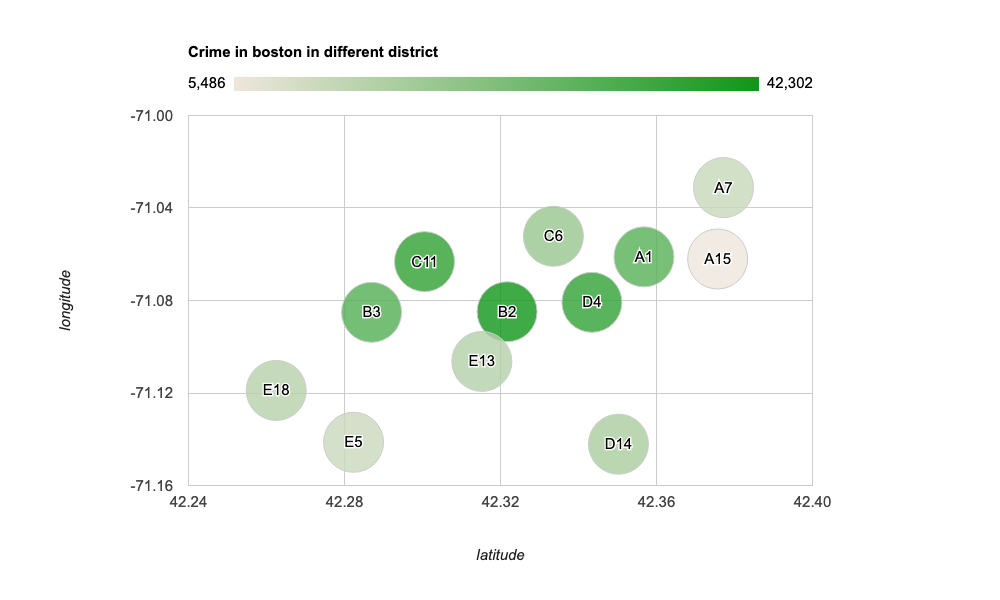

In [28]:
%%chart bubbles --data crime_map
title: Crime in boston in different district
height: 600
width: 1000
hAxis:
  title: latitude
vAxis:
  title: longitude

#### 2.2.3 Location,Housing Prices and Crimes

We are interested in finding a relationship between crimes and housing prices

#### Question: Do housing prices have effects on the number of crimes?

##### Distribution for Location_Housing price & Location_Crime

In [29]:
%%bq query
SELECT District, Housing_Price, count(District) as numcrime_in_district
FROM Boston_Crime.boston
Group By District, Housing_Price

QueryResultsTable job_FtF5wBhOH2Cymk9fu9Hwppvf_e8w

In [30]:
%%bq query -n housecrime
SELECT 
Housing_Price as x,
numcrime_in_district as y
FROM
(SELECT District, Housing_Price, count(District) as numcrime_in_district
FROM Boston_Crime.boston
Group By District, Housing_Price)

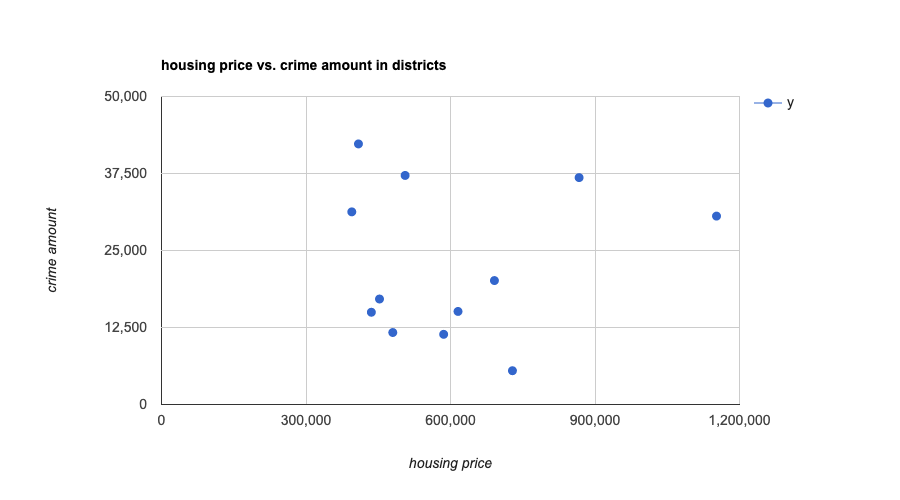

In [31]:
%%chart scatter --data housecrime
title: housing price vs. crime amount in districts
height: 500
width: 900
hAxis:
  title: housing price
vAxis:
  title: crime amount

In [32]:
%%bq query
create or replace model`team-6-is-perfect.Boston_Crime.regression2`
options(
model_type='linear_reg',
input_label_cols=['numcrime_in_district'])
as (SELECT
Housing_Price,
numcrime_in_district
FROM
(SELECT District, Housing_Price, count(District) as numcrime_in_district
FROM Boston_Crime.boston
Group By District, Housing_Price)
)

QueryResultsTable job_S8LW7vjiPzXTolkXSN0TOXrUDPWC

##### Regression for Location_Housing price & Location_Crime

In [33]:
%%bq query
with regression2_table as
(SELECT
Housing_Price,
numcrime_in_district
FROM
(SELECT District, Housing_Price, count(District) as numcrime_in_district
FROM Boston_Crime.boston
Group By District, Housing_Price)
)
select *
from
ML.evaluate( model`team-6-is-perfect.Boston_Crime.regression2`, table regression2_table)

QueryResultsTable job_jvfWXADvsbJDv8nZtTepi_oRMhCQ

In [34]:
%%bq query
with eval2_table as
(SELECT
Housing_Price,
numcrime_in_district
FROM
(SELECT District, Housing_Price, count(District) as numcrime_in_district
FROM Boston_Crime.boston
Group By District, Housing_Price)
)

select *
from
ML.WEIGHTS( model`team-6-is-perfect.Boston_Crime.regression2`, STRUCT(true AS standardize))

QueryResultsTable job_oJqVGK6S6VBHL1YqzM9mrnjMGVO2

#### Answer:
#### Regression function: predicted number of crime = 22751.215 + 909.399 * Housing_Price
#### R-square is 0.006 which is not a reliable regression

#### 2.2.4 Location_Income & Location_Crime

#### Question: Do incomes have effects on the amount of crimes?

##### Distribution for Location_Income & Location_Crime

In [35]:
%%bq query
SELECT District, Income, count(District) as numcrime_in_district
FROM Boston_Crime.boston
GROUP By District, Income

QueryResultsTable job_4fVDqpbqFLlUefBs8Mu0Uqc63QQX

In [36]:
%%bq query -n incomecrime
SELECT 
Income as x,
numcrime_in_district as y
FROM
(SELECT District, Income, count(District) as numcrime_in_district
FROM Boston_Crime.boston
Group By District, Income)

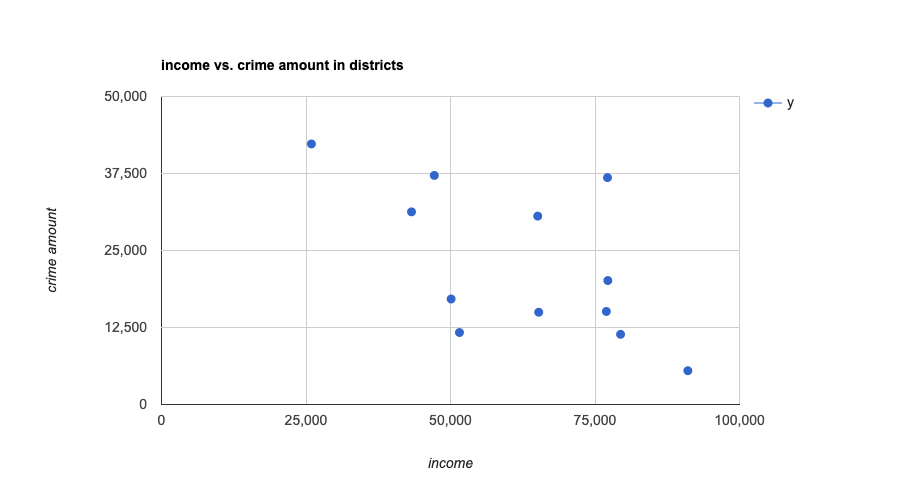

In [37]:
 %%chart scatter --data incomecrime
title: income vs. crime amount in districts
height: 500
width: 900
hAxis:
  title: income
vAxis:
  title: crime amount

##### Regression for Location_Income & Location_Crime

In [38]:
%%bq query
create or replace model`team-6-is-perfect.Boston_Crime.regression3`
options(
model_type='linear_reg',
input_label_cols=['numcrime_in_district'])
as (SELECT
Income,
numcrime_in_district
FROM
(SELECT District, Income, count(District) as numcrime_in_district
FROM Boston_Crime.boston
Group By District, Income)
)

QueryResultsTable job_wXtb8MmHlLkulrmbHz23yM914cBr

In [39]:
%%bq query
with regression3_table as
(SELECT
Income,
numcrime_in_district
FROM
(SELECT District, Income, count(District) as numcrime_in_district
FROM Boston_Crime.boston
Group By District, Income)
)

select *
from
ML.evaluate( model`team-6-is-perfect.Boston_Crime.regression3`, table regression3_table)

QueryResultsTable job_COfKqrNW4JIIY2JZS44_bf8UjUZc

In [40]:
%%bq query
with eval3_table as
(SELECT
Income,
numcrime_in_district
FROM
(SELECT District, Income, count(District) as numcrime_in_district
FROM Boston_Crime.boston
Group By District, Income)
)

select *
from
ML.WEIGHTS( model`team-6-is-perfect.Boston_Crime.regression3`, STRUCT(true AS standardize))

QueryResultsTable job_ls678a61_yQdrxGVG_fmcnourZN8

#### Answer:
#### Regression function: predicted number of crime = 22751.215 - 7330.979 * Income
#### R-square is 0.365 which is a partial reliable regression

### 2.3 Crime Attribute Analysis

#### 2.3.1 Crime Types

#### Question: What is the most common crime in Boston? 

In [41]:
%%bq query
SELECT Crime_Type, count(Crime_Type) as CrimeFrequency
FROM Boston_Crime.boston
Group by Crime_Type
Order by CrimeFrequency DESC 
LIMIT 3; 

QueryResultsTable job_d-1g1a9G7fsQtEv55voeBt1Pq0PT

#### Answer: Larceny is the most common crime in Boston and the second is Medical Assistance

### Particularly, we analyze incidences of shootings

#### 2.3.2 Example.shooting

#### Question: How many shootings were reported during the four years?

In [42]:
%%bq query 
SELECT COUNT(shooting) AS TotalShootingOffense
FROM Boston_Crime.boston
Where shooting = 1

QueryResultsTable job_7lIPi2NwyBdldHOE_WLBaa_HfHfM

#### Answer: There are 1012 incidences of shooting reported over the four years.

In [43]:
%%bq query -n shooting_in_month
SELECT TIMESTAMP(CONCAT(CAST(EXTRACT(year from OCCURRED_ON_DATE) AS STRING), "-", CAST(EXTRACT(month from OCCURRED_ON_DATE) AS STRING), "-01")) year_month, count(shooting) as shooting_in_month_base 
FROM Boston_Crime.boston
WHERE SHOOTING = 1
GROUP BY year_month
ORDER BY year_month;

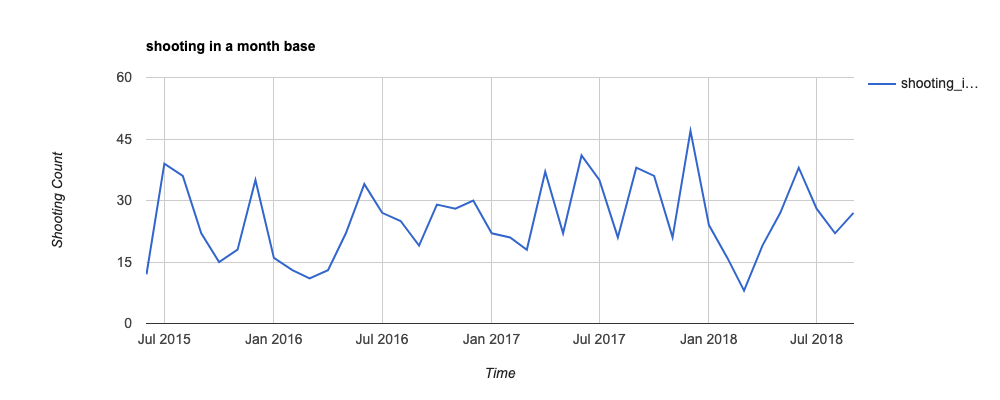

In [44]:
%%chart line --d shooting_in_month
title: shooting in a month base
height: 400
width: 1000
hAxis:
  title: Time
vAxis:
  title: Shooting Count

#### Based on the data, there are more than 15 shootings in each month on average.

### 2.4 Multivariate Analysis

#### 2.4.1 Location & Crime Type

In [45]:
%%bq query
SELECT Street, Crime_Type, count(INCIDENT_NUMBER) as numcrime
FROM Boston_Crime.boston
Group by street,Crime_Type
Order by numcrime DESC
LIMIT 10

QueryResultsTable job_LOWGCDG2Bg_W0eGg7HnrUdt879ku

#### Incidences of larceny happened frequently on Boylston Street

#### 2.4.2 Crime Type & Time

In [46]:
%%bq query
SELECT hour,Crime_Type, count(INCIDENT_NUMBER) as numcrime
FROM Boston_Crime.boston
Group by hour,Crime_Type
Order by numcrime DESC
LIMIT 10

QueryResultsTable job_2IS29sod758hsZn5GOYss-HufLAX

#### Larceny occur frequently in the noon

#### 2.4.3 Time & Location

In [47]:
%%bq query
SELECT hour,DISTRICT, count(INCIDENT_NUMBER) as numcrime
FROM Boston_Crime.boston
Group by hour,DISTRICT
Order by numcrime DESC
LIMIT 10

QueryResultsTable job_NcTeGXNRS-_b13qxRBj3qnb_R5Z2

#### District B2(Roxbury) is on the top of the crime list when grouped by hour and district.

### 3. Summary
Based on our analysis above, Boston is a safe city in general. The most frequent crimes are Larceny. Crimes are more likely to happen on Washington St., the longest street in Boston, as well as in Roxbury. Most crimes happen during 4 pm to 7 pm. Housing prices don’t have a statistically significant effect on crimes, but income has partial significance to crimes. 
Hope our project will help you survive in Boston!!!